# **Basics of Mobile robotics**
### **Project**

**Paul Huot-Marchand** 
**Luca Seelbach**
**Manuela Waible** 
 

**Date:** *2025*

# **INTRODUCTION**
Our project take place on a rectangular white environment with black obstacles of any shapes a black circle as goal and a  black isocele triangle on the robot. The goal was to implement global navigation using the camera provided creating a global occupancy map, then applying an A* algorithm to find an optimized path. A filter was implemented to track position of the robot. Local avoidance was implemented to avoid la minuit added obstacles using thymio infrared sensors.

## **I Computer Vision**
The steps of our computer vision part is as follow : 
- Detect the environment,
- Correct percpective,
- detect obstacles and goal to fill occupancy map
- detect the robot

To do so a general filtering framework was adopted. First convert to gray scale, apply bilateral filter to enhance edge and remove noise, apply canny filter to detect edges, apply morphological filter to close as much as possib

In [2]:
!pip install tdmclient numpy scipy opencv-python tqdm


In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import cv2
import tqdm
from Computer_vision import cv as com
#import Filtering as flt 
from Global_Nav import global_nav as gb
import matplotlib.pyplot as plt

import math as m
import numpy as np
from collections import deque
from matplotlib.animation import FuncAnimation

from Filtering import Control_fromEKF as control
from Filtering import Filtering as filt
from Local_Nav import local_nav as ln



In [45]:
# Initiate the communication between the Thymio and the computer
from tdmclient import ClientAsync, aw
client = ClientAsync()

node = await client.wait_for_node()
await node.lock() 

Node 7e5a04de-7cbe-4397-8545-f33016b69c2f

In [89]:
# to stop it
aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
aw(node.unlock())

In [3]:
def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale

#================HYPERPARAMETESRS======================

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 5
B2_O = 50
B3_O = 50
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0
M_O = 5
D_O = 5

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 8
B2_C = 70
B3_C = 70
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 80
B3_T = 80
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
#Min_area_env = 1920*1080*0.01   #Min area in pixel of the env
Min_area_env = 1000
Env_approx = 0.1

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of the env
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.2   #Min area in pixel of the env
Max_area_rob =  (L_T_p*H_T_p /2) * 1.8
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = False
#========================================================

In [4]:
# connect to camera

if DEBUG : 
    import matplotlib.pyplot as plt
    %matplotlib inline
#GLOBAL FRAMEWORK TO USE VISION
#EXECUTE CELL ABOVE WITH DEBUG = TRUE FOR TUNING UNTIL EVERYTHING IS CORRECTLY FILTERED AND FOUND
cap = cv2.VideoCapture(1)
    
if not cap.isOpened():
    print("Could not access webcam")






ROBOT FOUND
MAP ANALYZED : 
GOAL FOUND
ROBOT FOUND


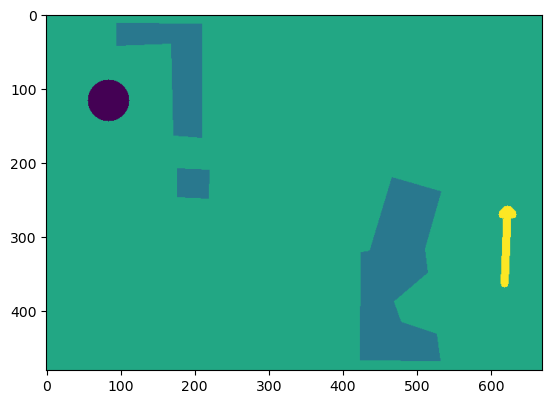

In [7]:
#INITIALIZATION
#GET A FRAME
img = com.get_picture_optimized(cap)
#img = cv2.imread("02.png")
#COMPUTE TRANSFORMATION MATRIX
matrix = com.matrix_perspective(img)
#CORRECT IMAGE
transformed_image = com.convert_perspective(img,matrix)

#PLOTTING
if DEBUG: 
    plt.figure()
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.title("Perspective Corrected Image")
    plt.axis('off')
    plt.show()


#GET GLOBAL MAP
global_map = com.get_map(transformed_image)

#GET ROBOT POSITION AND ORIENTATION
robot = com.get_robot(transformed_image)


length = 100
end_x = int(robot[0][0] + length * np.cos(robot[1]))
end_y = int(robot[0][1] + length * np.sin(robot[1]))
end_point = (end_x, end_y)
global_map4plot = global_map.copy()
cv2.arrowedLine(global_map4plot, [int(robot[0][0]), int(robot[0][1])], end_point, color=(2, 2, 2), thickness=10)
plt.imshow(global_map4plot)
plt.show()
if DEBUG : 
    global_map4plot = global_map.copy()
    cv2.arrowedLine(global_map4plot, robot[0], end_point, color=(2, 2, 2), thickness=10)
    plt.imshow(global_map4plot)
    plt.axis('off')
    plt.show()


In [93]:
global_map = global_map.astype(int)
solved = global_map[:]
path = path = gb.a_star(global_map, robot[1], 0.25, 
                 (int(round(robot[0][1])), int(round(robot[0][0]))))


480
670
158
98


In [ ]:
# help functions 
# Utility to pop waypoint if we pass it by local obstacle avoidance
thresh = 120
def dist_mm(p, q):
    return float(np.hypot(p[0] - q[0], p[1] - q[1]))

# Utilities to add global obstacles to repulsion vector in local obstacle avoidance
EPSILON = 1e-2
def add_unknown_repulsion(curr_pos, unknown_cells, UNKNOWN_WEIGHT=0.5, p=1.0, max_range=15.0):
    """
    curr_pos: (x_cm, y_cm)
    unknown_cells: iterable of (x_cm, y_cm) of the centers of -1 cells
    UNKNOWN_WEIGHT: small global weight
    p: distance power for attenuation
    max_range: ignore far unknowns (cm) to limit computation/noise
    """
    rx, ry = curr_pos
    ux, uy = 0.0, 0.0
    for cx, cy in unknown_cells:
        dx = rx - cx
        dy = ry - cy
        d = m.hypot(dx, dy)
        if d < 1e-6 or d > max_range:
            continue
        # unit vector from cell to robot
        ux += (dx / d) * (1.0 / ((d + EPSILON)**p))
        uy += (dy / d) * (1.0 / ((d + EPSILON)**p))
    return (UNKNOWN_WEIGHT * ux, UNKNOWN_WEIGHT * uy)

def unknown_cells_world(grid, cell_size_cm_x, cell_size_cm_y):
    """
    Turn indices of -1 cells into world coordinates (cm).
    origin_world_cm: (x0_cm, y0_cm) of grid cell (0,0)
    res_cm: cell size (cm)
    """
    x0, y0 = (0, 0)
    cells = []
    H, W = len(grid), len(grid[0])
    for i in range(H):
        for j in range(W):
            if grid[i][j] == -1:
                cx = x0 + (j + 0.5) * cell_size_cm_x
                cy = y0 + (i + 0.5) * cell_size_cm_y
                cells.append((cx, cy))
    return cells


            
            


In [59]:
from Computer_vision import cv as com
import cv2
import time
import numpy as np
from Global_Nav import global_nav as gb

WAIT_TIME = 0.2
async def main():
    #---- VIZUALIZATION PARAMETERS ----
    # Set camera resolution
    w = 1920
    h = 1080
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, w)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, h)
    cap.set(cv2.CAP_PROP_EXPOSURE, -7)
    time.sleep(0.1)  # let the camera apply settings
    
    # Desired display size
    display_width = 960
    display_height = 540
    
    
    #---- INITIALIZATION ---
    ret, frame = cap.read()
    matrix = com.matrix_perspective(frame)
    transformed_frame = com.convert_perspective(frame, matrix)
    
    
    global_map = com.get_map(transformed_frame)
    robot = com.get_robot(transformed_frame)
    #solved = global_map[:]
    #FIND PATH
    scaling = 0.3
    path = path = gb.a_star(global_map, robot[1], scaling, 
                     (int(round(robot[0][1])), int(round(robot[0][0]))))
    
    #print(path)
    #--- NAVIGATION PARAMETERS ---
    
    # params ekf
    Ts = 0.1  # time step in seconds
    L = 95  # distance between wheels in mm
    speed_to_mms = 0.3375  # conversion factor from thymio speed units to mm/s from solution ex.8 
    # Process noise for EKF (tune) (from model-mismatch/random-walk/control execution)
    q_proc = (
        1e-10, 1e-10, 1e-3,   # q_x, q_y, q_theta (model mismatch)
        75.72,  0.002692,         # q_v_ctrl, q_omega_ctrl (control execution noise)
        1e-2, 1e-5          # q_v_bias, q_omega_bias (random walk on v, omega)
    )
    # Camera measurement noise (tune)
    r_cam = (1.435, 1.864, 0.001496)  # [mm^2, mm^2, rad^2]
    r_mot = (75.72, 0.002692)    # motor noise on v, omega
    
    def pixel_to_world_mm(pos):
        px, py = pos
        x = 10 * px * (L / SIZE[1])
        y = 10 * py * (81.3 / SIZE[0])
        return x, y
    
    conv_x = 10 * (L / SIZE[1])
    conv_y = 10 * (81.3 / SIZE[0])
    # 1) buffers
    traj = deque(maxlen=2000)   # (x,y)
    # convert path!
    waypoints = control.remove_collinear(control.grid_to_mm(path, cell_size_mm_x=conv_x, cell_size_mm_y=conv_y))
    step_count = 0
    kidnap_first = False
    kidnap_second = False
    # kidnapping help function
    async def test_kidnap():
        kidnap_thresh = 500  # off ground
        # Kidnap check
        if np.mean(np.array(node["prox.ground.delta"][:])) < kidnap_thresh :
            print("kidnapped")
            print(np.array(node["prox.ground.delta"][:]))
            return True
        else:
            return False
    
    def update_kidnap(waypoints, ekf_traj):
        # Compute distances between last three positions
        p1 = ekf_traj[-1][0:2]
        p2 = ekf_traj[-2][0:2]
        # Compute midpoint of the pair that gave the min distance
        mean = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
        # compute distances to waypoints
        distance_waypoints = [dist_mm(mean, wps) for wps in waypoints]
        min_index = np.argmin(distance_waypoints)
        return min_index
            
    # global obstacle repulsion map
    # Build unknown cells list once per few cycles to save time
    unk_cells = unknown_cells_world(global_map, conv_x/10, conv_y/10)
    #sleep_time = 1 # sleep in obstacle avoidance for this number of loops
    #loop_count = 0
    
    # --- INIT EKF----
    #image = transformed_frame
    pos, angle, __ = com.get_robot(transformed_frame)
    pos = pixel_to_world_mm(pos)
    x = pos[0]
    y = pos[1]
    x0=[x, y, angle,0,0]
    ekf = filt.EKFState(x0, P0=1000*np.eye(5))
    #print(ekf)
    
    # --- PLOTTING ---
    ekf_traj = [] # for plot
    # memory for plots
    def ekf_get_state():
        s = ekf.get_state()  # (x,y,theta)
        ekf_traj.append((s[0], s[1], s[2]))  # log x,y each time it's called
        return s
    
    
    #---VISU---
    for i in path : 
        global_map[i[0]][i[1]] = -4 # marker for path in my debug functions
        
    def draw_static_map(global_map, path):
        # Choose a base canvas size matching your transformed frame
        H, W = len(global_map), len(global_map[0])
        
        static = np.full((H, W, 3), 255, dtype=np.uint8)
        
        grown_map = gb.obstacle_scale(global_map.copy(), scaling)
        gm = np.asarray(grown_map)
        obst_y, obst_x = np.where(gm == -1)
        static[obst_y, obst_x] = (0, 255, 255)
        
        gm = np.asarray(global_map)
        obst_y, obst_x = np.where(gm == -1)
        static[obst_y, obst_x] = (0, 0, 255)  # BGR

        # Optional: other map markers (e.g., -3 in blue)
        extra_y, extra_x = np.where(gm == -3)
        static[extra_y, extra_x] = (255, 0, 0)

        # Path (green) drawn once
        for (i, j) in path:
            cv2.circle(static, (j, i), 2, (0, 255, 0), -1)

        return static
    
    static_map_img = draw_static_map(global_map, path)
    
    drawing_robot_real = []
    
    #--- CONNECT TO THYMIO ---
    try:
        aw(node.lock()) # lock the node for R/W
    except Exception:
        pass # ignore it it wasn't locked
    
    aw(node.stop())
    print("Connected:", node)
    motors = aw(node.wait_for_variables({"motor.left.speed","motor.right.speed"}))
    
    
    #--- HELPER FUNCTIONS FOR EKF --- 
    def get_motor_meas(): 
        # raw speeds in Thymio units (instantaneous)
        vl = int(node.v.motor.left.speed)
        vr = int(node.v.motor.right.speed)
        #print("get_motor_meas", vl, vr)
        # convert to v [mm/s], omega [rad/s] 
        v, w = filt.motors_to_vw(vl, vr, speed_to_mms, L) 
        return np.array([v, w], dtype=float)
    
    def get_cam_meas(image=None):
        # get position from camera
        if image is not None:
            pos, angle, Rob = com.get_robot(image)
            #x = SIZE[1] - pos[0] 
            if Rob ==  False:
                return None
            pos = pixel_to_world_mm(pos)
            x = pos[0]
            y = pos[1]
            #print("Camera Robot Position", x, y, angle)
            return np.array([x, y, angle], dtype=float)
        return None
    
    
    
    obstacle_not_passed = False
    stop = False
    
    while True:
        
        #--- GET IMAGE ---
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame")
            break
    
        # Apply perspective transform
        transformed_frame = com.convert_perspective(frame, matrix)
        transformed_frame_visu = transformed_frame.copy() 
        # transformed_frame = current image we can work with
    
    
        #--- VISU ---
        # Start from cached static image (cheap copy)
        vis = static_map_img.copy()

        # Overlay dynamic info
        robot_px, robot_py, found = None, None, False
        robot, angle, found = com.get_robot(transformed_frame)

        if found:
            # Draw robot arrow
            length = 20
            p0 = (int(robot[0]), int(robot[1]))
            p1 = (int(robot[0] + length*np.cos(angle)),
                int(robot[1] + length*np.sin(angle)))
            cv2.arrowedLine(vis, p0, p1, color=(20, 20, 20), thickness=2, tipLength=0.3)
            
            drawing_robot_real.append(p0)
            
            
            #found = False
            
        for i in range(len(drawing_robot_real)):
                robot1 = drawing_robot_real[i]
                
                #end_point = drawing_robot_real[i][1]
                cv2.circle(vis, robot1, 2, (0,0,255), -1)
                
        # Optional: show a status message
        

        H, W = vis.shape[:2]
        box_h = 48 # banner height in pixels 
        y0 = H - box_h
        status_overlay = vis.copy()
        cv2.rectangle(status_overlay, (0, y0), (W, H), (255, 255, 255), thickness=-1) # white bar
        vis = cv2.addWeighted(status_overlay, 0.6, vis, 0.4, 0.0)
        msgs = []
        if found : msgs.append(("Robot Found", (0, 128, 0))) # green 
        if obstacle_not_passed: msgs.append(("Local obstacle detected", (0, 0, 255))) # red
        if kidnap_first: msgs.append(("KIDNAPPED", (0, 0, 255)))
        x_text = 16 
        y_text = y0 + 30 # baseline inside the bar 
        for k, (msg, color) in enumerate(msgs):
            cv2.putText(vis, msg, (x_text + 250*k, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)
        
        # Display
        #overlay = static_map_img
        #alpha_overlay = 0.6 
        #vis = cv2.addWeighted(transformed_frame, 1.0, overlay, alpha_overlay, 0.0)
        cv2.imshow("Transformed Camera Feed", cv2.resize(vis, (display_width, display_height)))
        
    
        #--- Camera Window ---
        # Show the transformed frame live
        small_transformed = cv2.resize(transformed_frame_visu, (display_width, display_height))
        cv2.imshow("Transformed Camera", small_transformed)
    
        # Resize for display only
        small_frame = cv2.resize(frame, (display_width, display_height))
    
        # Show the live frame
        cv2.imshow("Live Camera Feed", small_frame)
        
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
            aw(node.unlock())
            break
    
        
        #--- GlOBAL NAVIGATION ---
         # final loop
        if step_count < len(waypoints):
            # get motion params
            vl_cmd, vr_cmd = control.get_cmd()
            z_mot= get_motor_meas()
            z_cam = get_cam_meas(transformed_frame)
            
            # EKF STEP
            ekf.step(vl_cmd, vr_cmd, z_cam, r_cam=r_cam, z_mot=z_mot, r_mot=r_mot, Ts=Ts, q_proc=q_proc)
            #print("ekf results:", ekf.x, ekf.P)
            state = ekf_get_state()
            # motion control
            #print("waypoints:", waypoints)
            
            #--- LOCAL AVOIDANCE --- 
            if not(ln.prox_less_threshold(list(node["prox.horizontal"][:5]), 1500)) or obstacle_not_passed :
                print("here")
                print(list(node["prox.horizontal"][:5]))
                #print((list(node["prox.horizontal"][:5]), 700))
                objectif = (waypoints[step_count][0]/10, waypoints[step_count][1]/10) 
                curr_dir = (100*m.cos(state[2]), 100*m.sin(state[2]))
                curr_pos = (state[0]/10, state[1]/10)
                obstacle_not_passed = True
                await node.wait_for_variables({"prox.horizontal"})
                prox_read = list(node["prox.horizontal"])
                
    
                #--- TEST IF OBSTACLED IS PASSED ---
                if (ln.prox_less_threshold(prox_read, 1000)) and obstacle_not_passed:
                    #print("PASSED")
                    aw(control.set_motors(node,100,100))
                    await client.sleep(1.5)
                    obstacle_not_passed = False
                    #if loop_count > sleep_time:  # non blocking sleep time (to get camera and filter updates)
                    #    obstacle_not_passed = False
                    #    loop_count = 0
                    #loop_count += loop_count
                    
                    while step_count < len(waypoints) and dist_mm((state[0], state[1]), waypoints[step_count]) < thresh:
                        #waypoints.pop(0)
                        step_count += 1
                    #waypoints = maybe_pop_waypoint(state, last_state, waypoints, pos_tol_mm=50.0)
                    continue
                
                vect = ln.vect_calculation(objectif, (curr_pos),curr_dir,  prox_read[:5], 150, debug=False)
                # added for global obstacles
                # Unknown repulsion:
                ux, uy = add_unknown_repulsion(curr_pos, unk_cells, UNKNOWN_WEIGHT=0.25, p=1.0, max_range=15.0)
                # Combine:
                vect = (vect[0] - ux, vect[1] - uy)
                #
                angle_command = m.atan2(vect[1], vect[0])
                delta_speed = np.sign(angle_command)*min(abs(angle_command/WAIT_TIME*800/m.pi), 300)
                left_speed = int(100+(delta_speed/2))
                right_speed = int(100-(delta_speed/2))
                aw(control.set_motors(node, left=left_speed, right=right_speed))
                #print(f" curr_pos = ({curr_pos[0]:.2f}, {curr_pos[1]:.2f}), vect = {angle_command:.2f} and delta_speed = {delta_speed:.2f}, curr_dir = ({curr_dir[0]:.2f}, {curr_dir[1]:.2f})")
                await client.sleep(ln.WAIT_TIME)
                continue
                #print(curr_dir, delta_speed*WAIT_TIME*m.pi/100, m.cos(delta_speed*WAIT_TIME*m.pi/100)
    
            #--- FOLLOW THE GLOBAL PATH ---
            obstacle_not_passed = False
            #print("CHECK")
            kidnap_first = aw(test_kidnap())
            if kidnap_first:
                kidnap_second = aw(test_kidnap()) # gives next waypoint to go to if kidnapped
            if not kidnap_first and kidnap_second: # two steps on ground
                step_count = update_kidnap(waypoints, ekf_traj)
                kidnap_second = False
            #print(step_count, type(step_count))
            step_count = await control.follow_path(node, state, waypoints, step_count, v_cmd=170, kp_heading=90.0,
                          pos_tol=12.0)
            await client.sleep(0.1)
            # stop when goal reached
            if step_count >= len(waypoints):
               stop = True
        
        if stop :
            aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
            aw(node.unlock())
            
    
        # quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
            aw(node.unlock())
            break
    

# run main
aw(main())

# Release resources
#cap.release()
cv2.destroyAllWindows()


ROBOT FOUND
MAP ANALYZED : 
GOAL FOUND
ROBOT FOUND
480
670
397
618
294909
ROBOT FOUND
Connected: Node 7e5a04de-7cbe-4397-8545-f33016b69c2f
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOU

![final path with camera frame, converted map frame and path plan/execution frame](pathtest.png)